In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomCrop, ColorJitter, GaussianBlur, RandomVerticalFlip

# **Image augmentation**

In [19]:

transform = transforms.Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomRotation(degrees=15),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307),(0.3081))
])


# **Dataloader**

In [20]:
train_df=datasets.FashionMNIST('./data',train=True,download=True,transform=transform)
test_df=datasets.FashionMNIST('./data',train=False,transform=transform)
train_df_load=torch.utils.data.DataLoader(train_df,batch_size=32,shuffle=True)
test_df_load=torch.utils.data.DataLoader(test_df,batch_size=32)


In [21]:
for X,y in train_df_load:
    print(X.shape)
    break

torch.Size([32, 1, 28, 28])


# **Model**

#Architecture
*   Conv2d -> ReLU
*   Conv2d -> BatchNorm2d -> ReLU -> Maxpool2d 
*   flatten
*   dropout -> FC Linear -> BatchNorm1d -> ReLU 
*   dropout -> FC Linear 

In [22]:
class FashionMNIST_Net(nn.Module):#a class named FashionMNIST_Net is defined, and it inherits from nn.Module
    def __init__(self):
        super(FashionMNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn1=nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.bn2=nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x=  self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x =  self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [23]:
model =FashionMNIST_Net()
model

FashionMNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Model parameter

In [24]:
for name, param in model.named_parameters(): #model parameter name and values
    if param.requires_grad:
        print(name, param.data)

conv1.weight tensor([[[[-2.8353e-01, -2.8583e-01,  5.0474e-02],
          [ 5.1866e-02, -2.2747e-01, -1.1450e-01],
          [ 1.0786e-01,  1.3504e-01,  1.4082e-01]]],


        [[[-5.3365e-02,  6.8607e-02, -2.5619e-01],
          [ 2.6437e-01,  1.3942e-02,  2.0444e-01],
          [ 1.5183e-01,  2.6353e-02, -1.9231e-01]]],


        [[[-9.4500e-02,  2.1964e-01, -1.6455e-01],
          [-2.5727e-01, -1.8192e-01, -6.0013e-02],
          [ 7.4381e-02, -2.0938e-01,  7.1652e-02]]],


        [[[-1.6274e-01,  8.8464e-02, -9.1228e-03],
          [ 1.2097e-01,  1.3575e-01, -3.2707e-01],
          [-1.2813e-01,  1.3275e-01,  1.8734e-01]]],


        [[[ 1.1191e-01, -1.9725e-02, -6.9302e-02],
          [ 8.0570e-02, -9.6195e-02, -2.0552e-01],
          [ 3.3332e-01, -1.0521e-01,  1.2079e-01]]],


        [[[ 1.5080e-01,  3.1242e-02, -2.9928e-01],
          [-2.5155e-01, -1.7113e-01, -2.0669e-01],
          [ 2.7303e-02, -1.6197e-01,  2.3896e-01]]],


        [[[ 1.6170e-01,  1.8741e-02, -2.3262e

# Loss function and optimizer

In [25]:
loss_fn = nn.CrossEntropyLoss() #for multiclass classification
optimizer=optim.SGD(model.parameters(),lr=0.01, weight_decay=0.01, momentum=.9) #L2 regularization #for penalty to the loss function
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1) #to adjust learning rate dynamically

# **Training and Validation**

In [29]:
lrs=[]
def train(model,optimizer,epoch):
    model.train()
    for batch, (data, target) in enumerate(train_df_load):
      
        output = model(data) #forward pass
        loss =loss_fn(output, target) #loss function
        loss.backward() #backward pass #to compute local gradient
        optimizer.step() #weight updation
        optimizer.zero_grad() #set zero to gradient

        lr=optimizer.param_groups[0]["lr"]

        if batch % 1000 == 0:
            print('Train Epoch: {} batch-{}\tLoss: {:.6f} Learning Rate: {}'.format(epoch, batch ,loss.item(),lr))
    lrs.append(lr)

In [39]:
true_labels = [] #for confusion matrix
predicted_labels = [] #for confusion matrix

In [32]:
def test(model):
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_df_load:
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy= 100 * correct / total
        print('Accuracy of the network on the test images: {} %'.format(accuracy))
        top1_error = 100 - accuracy
        print('Top-1 Error: {} %'.format(top1_error))


In [34]:
epochs=3
for epoch in range(1,epochs+1):
    train(model,optimizer,epoch)
    test(model)
    scheduler.step()

Train Epoch: 1 batch-0	Loss: 0.533629 Learning Rate: 0.01
Train Epoch: 1 batch-1000	Loss: 0.431178 Learning Rate: 0.01
Accuracy of the network on the test images: 78.23 %
Top-1 Error: 21.769999999999996 %
Train Epoch: 2 batch-0	Loss: 0.777186 Learning Rate: 0.001
Train Epoch: 2 batch-1000	Loss: 0.563058 Learning Rate: 0.001
Accuracy of the network on the test images: 83.06 %
Top-1 Error: 16.939999999999998 %
Train Epoch: 3 batch-0	Loss: 0.366869 Learning Rate: 0.0001
Train Epoch: 3 batch-1000	Loss: 0.472721 Learning Rate: 0.0001
Accuracy of the network on the test images: 84.0 %
Top-1 Error: 16.0 %


In [45]:
true_labels = [] #for confusion matrix
predicted_labels = [] #for confusion matrix

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_df_load:
    
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
                                
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy= 100 * correct / total
    print('Accuracy of the network on the 10000 test images: {} %'.format(accuracy))
    top1_error = 100 - accuracy
    print('Top-1 Error: {} %'.format(top1_error))

Accuracy of the network on the 10000 test images: 83.77 %
Top-1 Error: 16.230000000000004 %


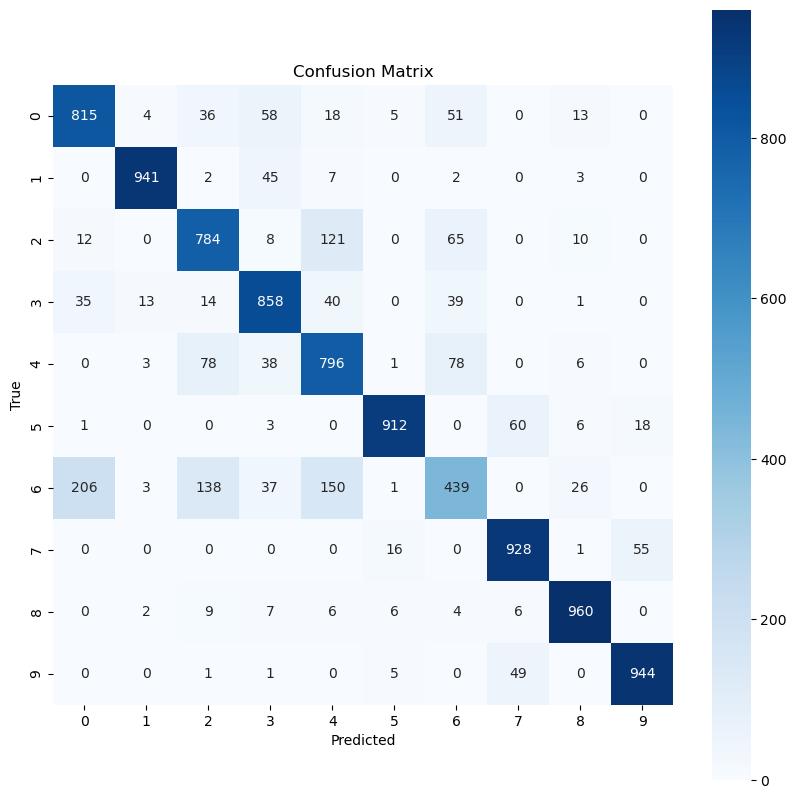

In [48]:
num_classes=10
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(num_classes, num_classes))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(true_labels, predicted_labels)
print('\n'+ report)